In [63]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [64]:
# import data
train = pd.read_csv(r'C:\Users\Lenny\Documents\Kaggle\Titanic\train.csv')
test = pd.read_csv(r'C:\Users\Lenny\Documents\Kaggle\Titanic\test.csv')
sample = pd.read_csv(r'C:\Users\Lenny\Documents\Kaggle\Titanic\gender_submission.csv')

In [65]:
# Parse variables with possible hidden meaning

# Parse name
def ParseNames(df):
    df['Surname'] = df['Name'].apply(lambda x: x.split(', ')[0])
    df['Title'] = df['Name'].apply(lambda x: x.split(', ')[1].split('. ')[0])
    df['SpecialTitle'] = df['Title'].apply(lambda x: x not in ('Mr', 'Mrs', 'Miss', 'Master'))
    df['Married'] = df['Title'].apply(lambda x: 'False' if x in ('Master', 'Miss') else 'True' if x == 'Mrs' else 'Unknown')

# Use ticket info
def ParseTicket(df):
    data = df.groupby('Ticket')['Ticket'].count() > 1
    shared_ticket = pd.DataFrame(
        data = data.values,
        index = data.index,
        columns = ['SharedTicket'],
    )
    temp = df.merge(
        shared_ticket,
        left_on='Ticket',
        right_index=True,
    )
    df['SharedTicket'] = temp['SharedTicket']
    
def ParseCabin(df):
    df['CabinLetter'] = df['Cabin'].fillna('Unknown').apply(lambda x: x[0] if x != 'Unknown' else 'Unknown')
    df['CabinNumberIsEven'] = df['Cabin'].fillna('Unknown').apply(lambda x: str(int(x[-1]) % 2 == 0) if x not in ['F', 'D', 'T', 'Unknown'] else 'Unknown')
    
ParseNames(train)
ParseTicket(train)
ParseCabin(train)
ParseNames(test)
ParseTicket(test)
ParseCabin(test)

In [66]:
# encode the variables that need to be encoded with one-hot encoding
from sklearn.preprocessing import OneHotEncoder

def TrainEncoder(data):
    le = OneHotEncoder(sparse=False)
    le.fit(data)
    return le

def ApplyEncoder(df, col, data, le):
    t_data = pd.DataFrame(
        data = le.transform(data),
        columns = [col + '_' + str(c) for c in le.categories_[0]]
    )
    df = df.merge(t_data, left_index=True, right_index=True)
    df.drop(columns = [c], inplace=True)
    return df

for c in ['Pclass', 'Sex', 'Embarked', 'Married', 'CabinLetter', 'CabinNumberIsEven']:
    # train encoder
    c_data = train[c].fillna('Unknown').values[:, None]
    enc = TrainEncoder(c_data)
    # apply the encoder inplace
    train = ApplyEncoder(train, c, c_data, enc)
    test = ApplyEncoder(test, c, test[c].fillna('Unknown').values[:, None], enc)

In [67]:
idx = train.isna().any() | test.isna().any()
missing_cols = idx[idx].index

full_data = pd.concat([train, test], axis=0).reset_index()
ind_cols = [
    'Age', 'Fare',
    'SibSp', 'Parch',
    'Pclass_1', 'Pclass_2', 'Pclass_3',
    'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Embarked_Unknown',
    'Married_False', 'Married_True', 'Married_Unknown', 'SharedTicket', 'SpecialTitle',
    'CabinLetter_A', 'CabinLetter_B',
    'CabinLetter_C', 'CabinLetter_D', 'CabinLetter_E', 'CabinLetter_F',
    'CabinLetter_G', 'CabinLetter_T', 'CabinLetter_Unknown',
    'CabinNumberIsEven_False', 'CabinNumberIsEven_True', 'CabinNumberIsEven_Unknown']
model_cols = ['Age', 'Fare']

from sklearn.linear_model import LinearRegression
for mc in model_cols:
    # get idx and cols
    train_idx = ~(full_data[mc].isna())
    train_cols = [c for c in ind_cols if c != mc]
    # set data
    train_x = full_data.loc[train_idx, train_cols]
    train_y = full_data.loc[train_idx, mc]
    # grab valid idx
    idx = ~train_x.isna().any(axis=1)
    lm = LinearRegression()
    lm.fit(train_x.loc[idx], train_y.loc[idx])
    # apply on the rows its needed
    for df in [train, test]:
        x = df.loc[
            df[mc].isna(),
            train_cols
        ]
        if x.shape[0] > 0:
            df.loc[x.index, mc+'_Approx'] = lm.predict(x)
    
for c in model_cols:
    for i, r in train.iterrows():
        if np.isnan(train.loc[i, c]):
            train.loc[i, c] = train.loc[i, c + '_Approx']
    for i, r in test.iterrows():
        if np.isnan(test.loc[i, c]):
            test.loc[i, c] = test.loc[i, c + '_Approx']


In [68]:
ind_cols = [
    'Age', 'Fare',
    'SibSp', 'Parch',
    'Pclass_1', 'Pclass_2', 'Pclass_3',
    'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Embarked_Unknown',
    'Married_False', 'Married_True', 'Married_Unknown', 'SharedTicket', 'SpecialTitle',
    'CabinLetter_A', 'CabinLetter_B',
    'CabinLetter_C', 'CabinLetter_D', 'CabinLetter_E', 'CabinLetter_F',
    'CabinLetter_G', 'CabinLetter_T', 'CabinLetter_Unknown',
    'CabinNumberIsEven_False', 'CabinNumberIsEven_True', 'CabinNumberIsEven_Unknown']
dep_cols = ['Survived']

def NormalizeCols(df):
    for c in df.columns:
        data = df.loc[:, c].values.astype(float)
        m1 = np.min(data)
        m2 = np.max(data)
        df.loc[:, c] = (data - m1) / (m2 - m1)
    return df
train_x = NormalizeCols(train.loc[:, ind_cols])
train_y = train.loc[:, dep_cols].values
test_x = NormalizeCols(test.loc[:, ind_cols])

from sklearn.model_selection import train_test_split
x1, x2, y1, y2 = train_test_split(train_x, train_y, test_size=0.3, random_state=42)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42, C=10**-1)
model.fit(x1, y1==1)
y1_hat = model.predict_proba(x1)[:, 1]
y2_hat = model.predict_proba(x2)[:, 1]
print(
metrics.roc_auc_score(y1, y1_hat),
metrics.roc_auc_score(y2, y2_hat))

0.8650664811379097 0.8708899982785332


C:\Users\Lenny\AppData\Local\Temp\ipykernel_13092\1390418506.py:18: RuntimeWarning: invalid value encountered in true_divide
  df.loc[:, c] = (data - m1) / (m2 - m1)
C:\Users\Lenny\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
y2_hat[:, None]

array([[0.42740404],
       [0.20584894],
       [0.09498159],
       [0.74566867],
       [0.68984379],
       [0.70767299],
       [0.61615352],
       [0.09438898],
       [0.6204832 ],
       [0.87667396],
       [0.33132446],
       [0.09012897],
       [0.49945732],
       [0.16896427],
       [0.20395586],
       [0.84151312],
       [0.40378477],
       [0.6161559 ],
       [0.21701268],
       [0.26520055],
       [0.09415617],
       [0.17632661],
       [0.50775572],
       [0.09500054],
       [0.09312776],
       [0.24704813],
       [0.30719079],
       [0.20591823],
       [0.24974634],
       [0.51159165],
       [0.09518842],
       [0.51700245],
       [0.29478246],
       [0.51936983],
       [0.09539834],
       [0.17385689],
       [0.30450731],
       [0.61615352],
       [0.82518142],
       [0.09305706],
       [0.20856136],
       [0.08945117],
       [0.09305871],
       [0.13225396],
       [0.71220235],
       [0.08938592],
       [0.09519226],
       [0.094

In [70]:
import sklearn.metrics as metrics
# metrics.confusion_matrix(y2==1, y2_hat[:, None])
tpr1, fpr1, th1 = metrics.roc_curve(y1==1, y1_hat[:, None])
tpr2, fpr2, th2 = metrics.roc_curve(y2==1, y2_hat[:, None])

train:  0.8650664811379097
test:  0.8708899982785332


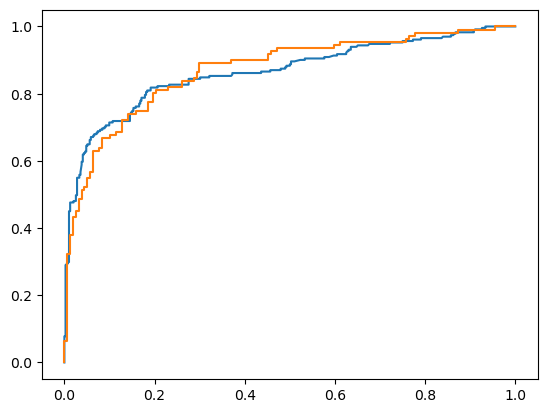

In [71]:
import matplotlib.pyplot as plt
plt.plot(tpr1, fpr1)
plt.plot(tpr2, fpr2)
print('train: ', metrics.roc_auc_score(y1, y1_hat))
print('test: ', metrics.roc_auc_score(y2, y2_hat))

In [79]:
test['Survived'] = model.predict(test.loc[:, ind_cols]).astype(int)

In [92]:
test.loc[:, ['PassengerId', 'Survived']].to_csv(r'C:\Users\Lenny\Documents\Kaggle\Titanic\submission.csv', index=False)

In [74]:
Notes:
- need to align datatypes at the beginning so you don't look like an idiot
- sklearn has encoders, probably need one-hot encoder to keep things simpler otherwise you have to make sure you use categoricals, etc. and that's annoying
- missing data needs to be considered and taken care of carefully
- didn't do any rescaling - need to remember that


SyntaxError: invalid syntax (1126875838.py, line 1)